In [1]:
            #%matplotlib widget
#%matplotlib ipympl
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit

'''
from matplotlib.ticker import LogFormatter 
from matplotlib import ticker, cm
import matplotlib as mpl
import copy
import os
import h5py
import json
import PyPDF2                       
import glob                         
from collections.abc import Iterable
import succolib as suc
import math
'''

import sys 
Swan_h = ("swan" in sys.executable) or ("cern" in sys.executable)
# print('Swan ', Swan_h)

import ipympl

## Specific run

In [2]:
######################## MATERIAL AND YEAR #####################
year = 2024
material = 'W_1.5mm'
######################## SET RUN NUMBER #####################
run = 720693
######################## SET CUT AND SELECTIONS #####################

Calibration = True
bins_2d = [100,100]
calo_th = 0.1

n_bin_calo = np.arange(calo_th,6.5,0.05)
Cut_pos = True
chamb_dim = [0,10]

if Cut_pos:
    # pos_cut_x= [4.9 ,4.9+0.8] 
    # pos_cut_y= [4.65,4.65+0.8]
    if run in range(720686,720693):
        pos_cut_x=[5.2,5.8]
        pos_cut_y=[4.7,5.45]
    elif run in range (720693,720700):
        pos_cut_x=[5.2,5.8]
        pos_cut_y=[4.7,5.55]
    else:
        # pos_cut_x= [5,5.6] 
        # pos_cut_y= [4.8,5.4]
        pos_cut_x= [5.2,5.5] 
        pos_cut_y= [4.8,5.2]

else:
    pos_cut_x= chamb_dim
    pos_cut_y= chamb_dim

theta_crit = 570 #urad
# theta_cut = 3*theta_crit
theta_cut = 1000
# theta_cut = 100000

print(pos_cut_x,pos_cut_y)

[5.2, 5.8] [4.7, 5.55]


In [3]:
import Utils
from Utils import *
dizi, mycmap = configurator(year,material,Swan_h)

m = dizi['slope_Calo']
q = dizi['intercept_Calo']


event acquired 55246 event survived 6778 survaival 12.269%
random  mean Calo 2.19 - mean APC 144.26
event acquired 296023 event survived 10465 survaival 3.535%
axial   mean Calo 2.46 - mean APC 207.84
 A/R : Calo 1.12 - APC 1.44


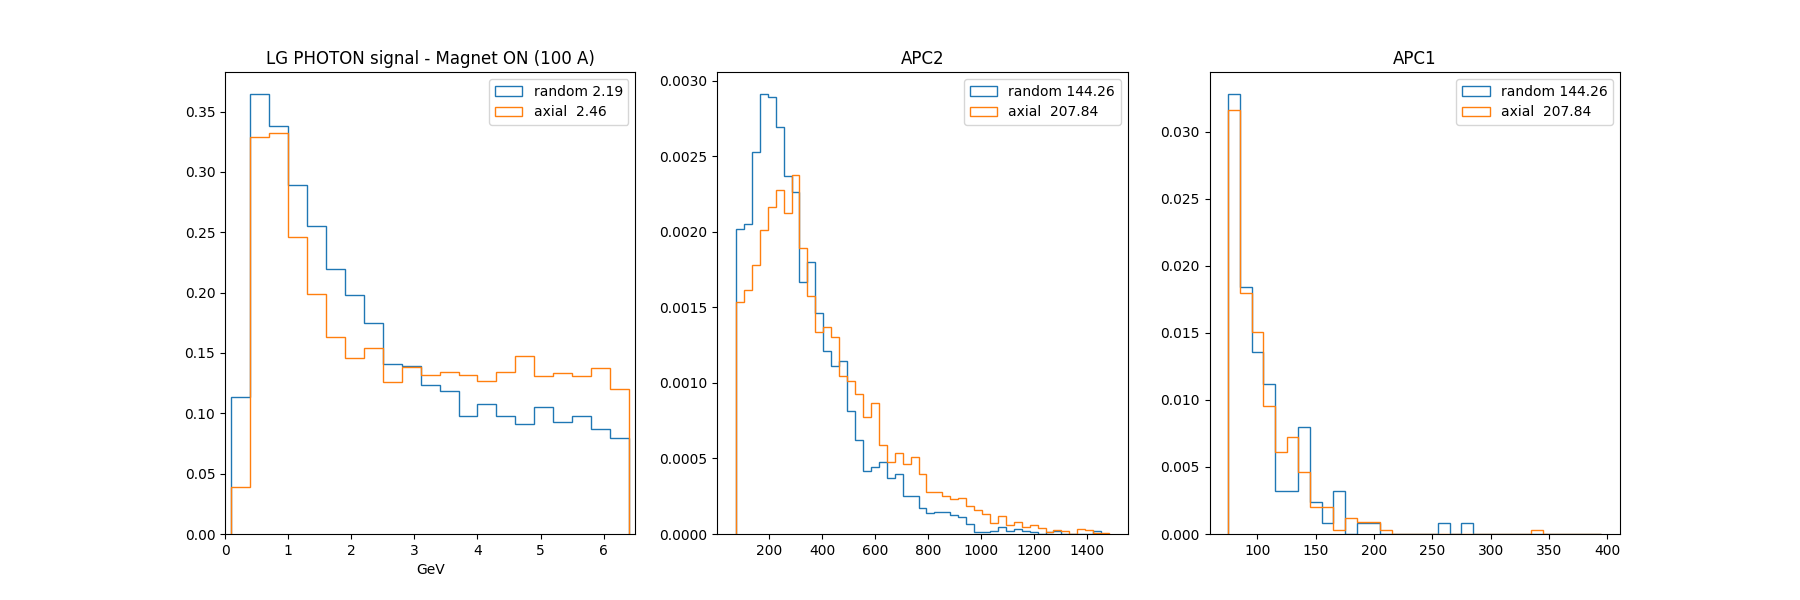

In [4]:
r_ax =[720635,720640,720641,720646,720647]
r_rn =[720648] 
runs = [r_rn,r_ax]    
# labels =    ['axial cut 1mrad', 'axial no cut']
labels =    ['random','axial ']
theta_cut = [10000000,1000]
time_index = [2,2]
# n_bin_calo = 50  
adc_th = 75
n_bin_apc2 = np.arange(adc_th,1500,30)  
n_bin_apc1 = np.arange(adc_th,400,10)  


Calibration = True


fig, ax = plt.subplots(1,3)
fig.set_size_inches(18, 6)
fig.subplots_adjust(hspace=.4)
calo_mean, apc_mean  = [], []
for i,r in enumerate(runs):
    xpos,xinfo,ph,tm,evi,info_plus,\
    Cherry1,Cherry2,Scinti_desy,Scinti_after_magnet,Calo_photon,Calo_elect1,Calo_elect2,Apc1,Apc2,\
    x1,y1,x2,y2,x_cry,y_cry,theta_in_x,theta_in_y = file_corrector(r)
    theta_in_x = theta_in_x - 2000
    
    shape_good = np.shape(Calo_photon)[0] 
    if Calibration:
        Calo_photon = (Calo_photon - q)/m
        Calo_elect1 = (Calo_elect1*3.8 - q)/m
        Calo_elect2 = (Calo_elect2*4.2- q)/m
        n_bin_calo = np.arange(0.1,6.5,0.3)  
        calo_th = 0.1
    else:
        calo_th = 10
        n_bin_calo = np.arange(calo_th,1500,40)  
    #############################################
    # logix = (x2>pos_cut_x[0]) & (x2<pos_cut_x[1])
    # logiy = (y2>pos_cut_y[0]) & (y2<pos_cut_y[1])
    logix = (x_cry>pos_cut_x[0]) & (x_cry<pos_cut_x[1])
    logiy = (y_cry>pos_cut_y[0]) & (y_cry<pos_cut_y[1])
    
    logi_pos = logix & logiy
    logi_calo = (Calo_photon > calo_th)
    logi_scinti = (Scinti_desy > 100)
    logi_cherry = Cherry1 >21
    logi_angle = ((theta_in_x)**2 + (theta_in_y)**2) < (theta_cut[i])**2
    logi_time = ((tm[:,time_index[i]]-tm[:,6]) < -18 ) & (tm[:,time_index[i]]-(tm[:,6]) > -21)  
    logi = logi_pos & logi_calo & logi_angle & logi_cherry & logi_time
    #############################################
    # logi =  logi_calo
    
    if Calibration:
        pesi = (6/4)*Calo_photon[logi]
        counts = np.shape(Calo_photon[logi]) 
        ax[0].hist((6/4)*Calo_photon[logi],bins=n_bin_calo, density=True, label= labels[i]  +f' {np.mean(Calo_photon[logi]):.2f}' , histtype='step')
    else:
        pesi = Calo_photon[logi]
        counts = np.shape(Calo_photon[logi]) 
        ax[0].hist(Calo_photon[logi],bins=n_bin_calo, density=True, label= labels[i] +f' {np.mean(Calo_photon[logi]):.2f}', histtype='step')
   
    print(f'event acquired {shape_good} event survived {counts[0]} survaival {100*counts[0]/shape_good:.3f}%' )
    # ax.hist(Calo_elect1[Calo_elect1>0.01],bins=n_bin_calo, density=True, label=f'Ce1{run[0]} {counts}', histtype='step')
    # ax.hist(Calo_elect2[Calo_elect2>0.01],bins=n_bin_calo, density=True, label=f'Ce2{run[0]} {counts}', histtype='step')
    if Calibration: 
        ax[0].set_xlim(0,6.5)
        ax[0].set_xlabel('GeV')
    else:   
        ax[0].set_xlabel('ADC')
    
    ax[1].hist(Apc2[logi],bins=n_bin_apc2, density=True, label= labels[i]  +f' {np.mean(Apc2[logi]):.2f}' , histtype='step')
    ax[2].hist(Apc1[logi],bins=n_bin_apc1, density=True, label= labels[i]  +f' {np.mean(Apc2[logi]):.2f}' , histtype='step')
    ax[0].set_title('LG PHOTON signal - Magnet ON (100 A)')
    ax[1].set_title('APC2')
    ax[2].set_title('APC1')
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    calo_mean.append(np.mean(Calo_photon[logi]))
    apc_mean.append(np.mean(Apc2[logi]))
    print(labels[i],f' mean Calo {(np.mean(Calo_photon[logi])):.2f} - mean APC {(np.mean(Apc2[logi])):.2f}')

print(f' A/R : Calo {calo_mean[1]/calo_mean[0]:.2f} - APC {apc_mean[1]/apc_mean[0]:.2f}')
plt.show()

event acquired 296023 event survived 35135 survaival 11.869%
axial no cut  mean Calo 2.54 - mean APC 203.22
event acquired 296023 event survived 10465 survaival 3.535%
axial no cut  1mrad  mean Calo 2.46 - mean APC 207.84
 A/R : Calo 0.97 - APC 1.02


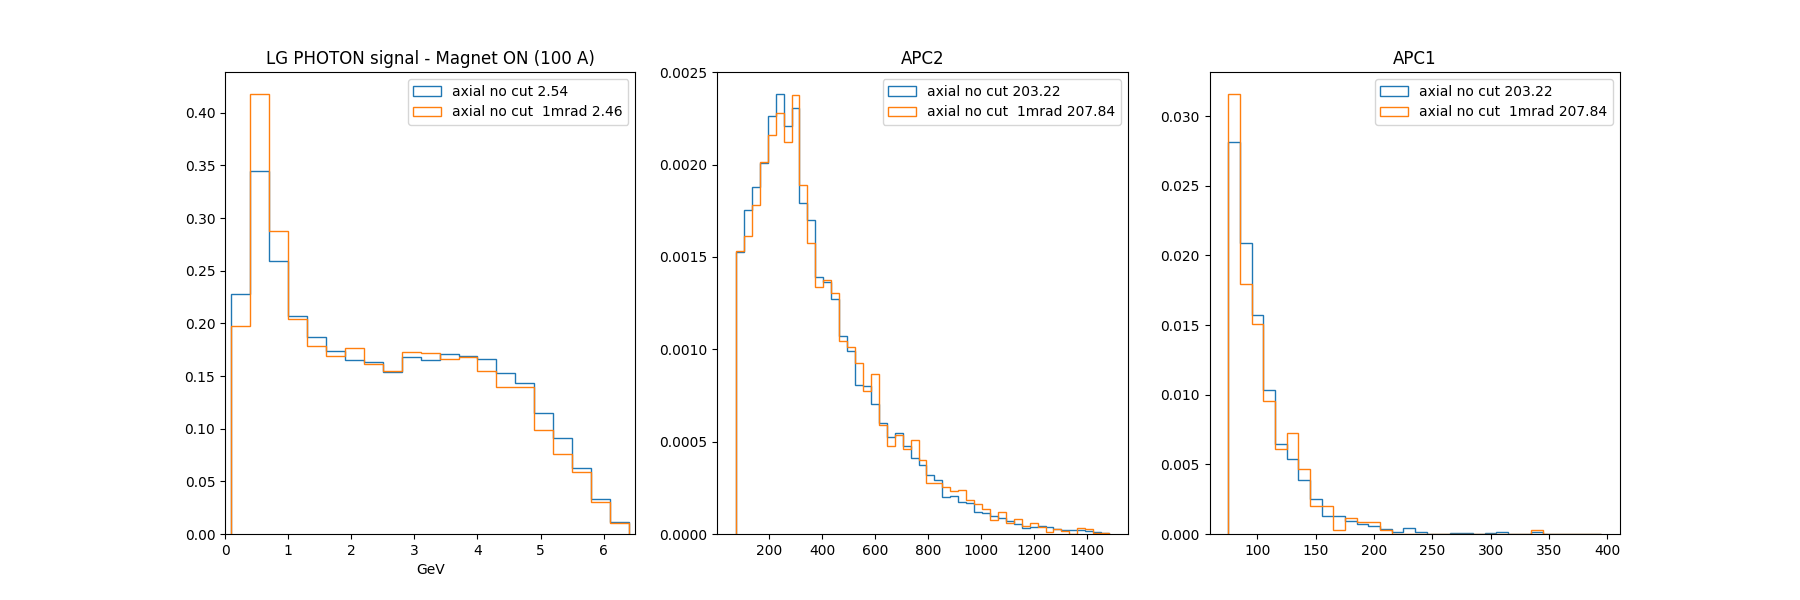

In [5]:
r_ax =[720635,720640,720641,720646,720647]
r_rn =[720648] 
runs = [r_ax,r_ax]    
labels =    ['axial no cut', 'axial no cut  1mrad']
# labels =    ['random','axial ']
theta_cut = [10000000,1000]
time_index = [2,2]
# n_bin_calo = 50  
adc_th = 75
n_bin_apc2 = np.arange(adc_th,1500,30)  
n_bin_apc1 = np.arange(adc_th,400,10)  


Calibration = True


fig, ax = plt.subplots(1,3)
fig.set_size_inches(18, 6)
fig.subplots_adjust(hspace=.4)
calo_mean, apc_mean  = [], []
for i,r in enumerate(runs):
    xpos,xinfo,ph,tm,evi,info_plus,\
    Cherry1,Cherry2,Scinti_desy,Scinti_after_magnet,Calo_photon,Calo_elect1,Calo_elect2,Apc1,Apc2,\
    x1,y1,x2,y2,x_cry,y_cry,theta_in_x,theta_in_y= file_corrector(r)
    theta_in_x = theta_in_x - 2000
    
    shape_good = np.shape(Calo_photon)[0] 
    if Calibration:
        Calo_photon = (Calo_photon - q)/m
        Calo_elect1 = (Calo_elect1*3.8 - q)/m
        Calo_elect2 = (Calo_elect2*4.2- q)/m
        n_bin_calo = np.arange(0.1,6.5,0.3)  
        calo_th = 0.1
    else:
        calo_th = 10
        n_bin_calo = np.arange(calo_th,1500,40)  
    #############################################
    # logix = (x2>pos_cut_x[0]) & (x2<pos_cut_x[1])
    # logiy = (y2>pos_cut_y[0]) & (y2<pos_cut_y[1])
    logix = (x_cry>pos_cut_x[0]) & (x_cry<pos_cut_x[1])
    logiy = (y_cry>pos_cut_y[0]) & (y_cry<pos_cut_y[1])
    
    logi_pos = logix & logiy
    logi_calo = (Calo_photon > calo_th)
    logi_scinti = (Scinti_desy > 100)
    logi_cherry = Cherry1 >21
    logi_angle = ((theta_in_x)**2 + (theta_in_y)**2) < (theta_cut[i])**2
    logi_time = ((tm[:,time_index[i]]-tm[:,6]) < -18 ) & (tm[:,time_index[i]]-(tm[:,6]) > -21)  
    logi = logi_pos & logi_calo & logi_angle & logi_cherry & logi_time
    #############################################
    # logi =  logi_calo
    
    if Calibration:
        pesi = Calo_photon[logi]
        counts = np.shape(Calo_photon[logi]) 
        ax[0].hist(Calo_photon[logi],bins=n_bin_calo, density=True, label= labels[i]  +f' {np.mean(Calo_photon[logi]):.2f}' , histtype='step')
    else:
        pesi = Calo_photon[logi]
        counts = np.shape(Calo_photon[logi]) 
        ax[0].hist(Calo_photon[logi],bins=n_bin_calo, density=True, label= labels[i] +f' {np.mean(Calo_photon[logi]):.2f}', histtype='step')
   
    print(f'event acquired {shape_good} event survived {counts[0]} survaival {100*counts[0]/shape_good:.3f}%' )
    # ax.hist(Calo_elect1[Calo_elect1>0.01],bins=n_bin_calo, density=True, label=f'Ce1{run[0]} {counts}', histtype='step')
    # ax.hist(Calo_elect2[Calo_elect2>0.01],bins=n_bin_calo, density=True, label=f'Ce2{run[0]} {counts}', histtype='step')
    if Calibration: 
        ax[0].set_xlim(0,6.5)
        ax[0].set_xlabel('GeV')
    else:   
        ax[0].set_xlabel('ADC')
    
    ax[1].hist(Apc2[logi],bins=n_bin_apc2, density=True, label= labels[i]  +f' {np.mean(Apc2[logi]):.2f}' , histtype='step')
    ax[2].hist(Apc1[logi],bins=n_bin_apc1, density=True, label= labels[i]  +f' {np.mean(Apc2[logi]):.2f}' , histtype='step')
    ax[0].set_title('LG PHOTON signal - Magnet ON (100 A)')
    ax[1].set_title('APC2')
    ax[2].set_title('APC1')
    
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    calo_mean.append(np.mean(Calo_photon[logi]))
    apc_mean.append(np.mean(Apc2[logi]))
    print(labels[i],f' mean Calo {(np.mean(Calo_photon[logi])):.2f} - mean APC {(np.mean(Apc2[logi])):.2f}')

print(f' A/R : Calo {calo_mean[1]/calo_mean[0]:.2f} - APC {apc_mean[1]/apc_mean[0]:.2f}')
plt.show()

In [6]:
## HYBRID SOURCE

In [7]:
#### radiator ####
r_ax =[720667]
r_rn_old=[720668] 
r_rn =[720671] 
# r_rn =[720671,720668] 

#### single crystal ####
r_ax_cry =[720688]
r_rn_cry =[720687]
# r_1_cry =[720689]
# r_2_cry =[720690]
# r_3_cry =[720691]
r_4_cry =[720692]
r_rn_cry2 =[720693]


###What to see ###
# runs = [r_ax,r_rn]   
# runs = [r_ax,r_ax_cry,r_rn, r_rn_cry]   
# labels =    ['axial', 'ax cry','rnd', 'rnd cry']
# runs = [r_ax_cry,r_rn_cry,r_1_cry,r_2_cry,r_3_cry,r_4_cry]   
# runs = [r_ax_cry,r_rn_cry,r_4_cry]   
# runs = [r_rn_cry,r_rn_cry2,r_4_cry]   
# labels =    ['axbg cry', 'rnd cry','axbg + 6mrad','axbg - 6mrad','axbg +12 mrad','axbg +30 mrad']
# labels =    ['axbg cry', 'rnd cry','axbg +30 mrad']
# labels =    ['rnd cry','rnd cry2','axbg +30 mrad']

runs = [i for i in range(720686,720693)]   
labels = [f'{i}' for i in range(720686,720693)]   


Cut_pos = True
chamb_dim = [0,10]

if Cut_pos:
    # pos_cut_x  = [5.2,5.5]  #ON X2 POS
    # pos_cut_y  = [4.8,5.2] #ON X2 POS
    # pos_cut_xc = [5.3,5.65]  #ON CRYSTAL POS
    # pos_cut_yc = [4.85,5.35] #ON CRYSTAL POS
    if run >720686:
        pos_cut_x=[5.0,5.85]
        pos_cut_y=[4.6,5.55]
    else:
        pos_cut_x= [5,5.6] 
        pos_cut_y= [4.8,5.4]
else:
    pos_cut_x= chamb_dim
    pos_cut_y= chamb_dim

720686
 mean ratio ON/OFF : PH 0.78 E1 0.11 PAD UP 1.83 PAD DW 1.72
 tot signal ratio ON/OFF : PH 0.78 E1 0.66 PAD UP 1.83 PAD UP 2.89

720687
 mean ratio ON/OFF : PH 1.14 E1 0.11 PAD UP 2.50 PAD DW 1.94
 tot signal ratio ON/OFF : PH 1.14 E1 0.54 PAD UP 2.50 PAD UP 1.64

720688
 mean ratio ON/OFF : PH 1.12 E1 0.07 PAD UP 2.67 PAD DW 1.83
 tot signal ratio ON/OFF : PH 1.12 E1 0.46 PAD UP 2.66 PAD UP 2.02

720689
 mean ratio ON/OFF : PH 1.08 E1 0.07 PAD UP 2.69 PAD DW 2.34
 tot signal ratio ON/OFF : PH 1.08 E1 0.44 PAD UP 2.68 PAD UP 2.06

720690
 mean ratio ON/OFF : PH 1.11 E1 0.07 PAD UP 2.67 PAD DW 1.65
 tot signal ratio ON/OFF : PH 1.11 E1 0.48 PAD UP 2.66 PAD UP 1.70

720691
 mean ratio ON/OFF : PH 1.11 E1 0.07 PAD UP 2.68 PAD DW 2.49
 tot signal ratio ON/OFF : PH 1.11 E1 0.45 PAD UP 2.68 PAD UP 2.19

720692
 mean ratio ON/OFF : PH 1.11 E1 0.08 PAD UP 2.61 PAD DW 1.71
 tot signal ratio ON/OFF : PH 1.11 E1 0.50 PAD UP 2.61 PAD UP 2.07



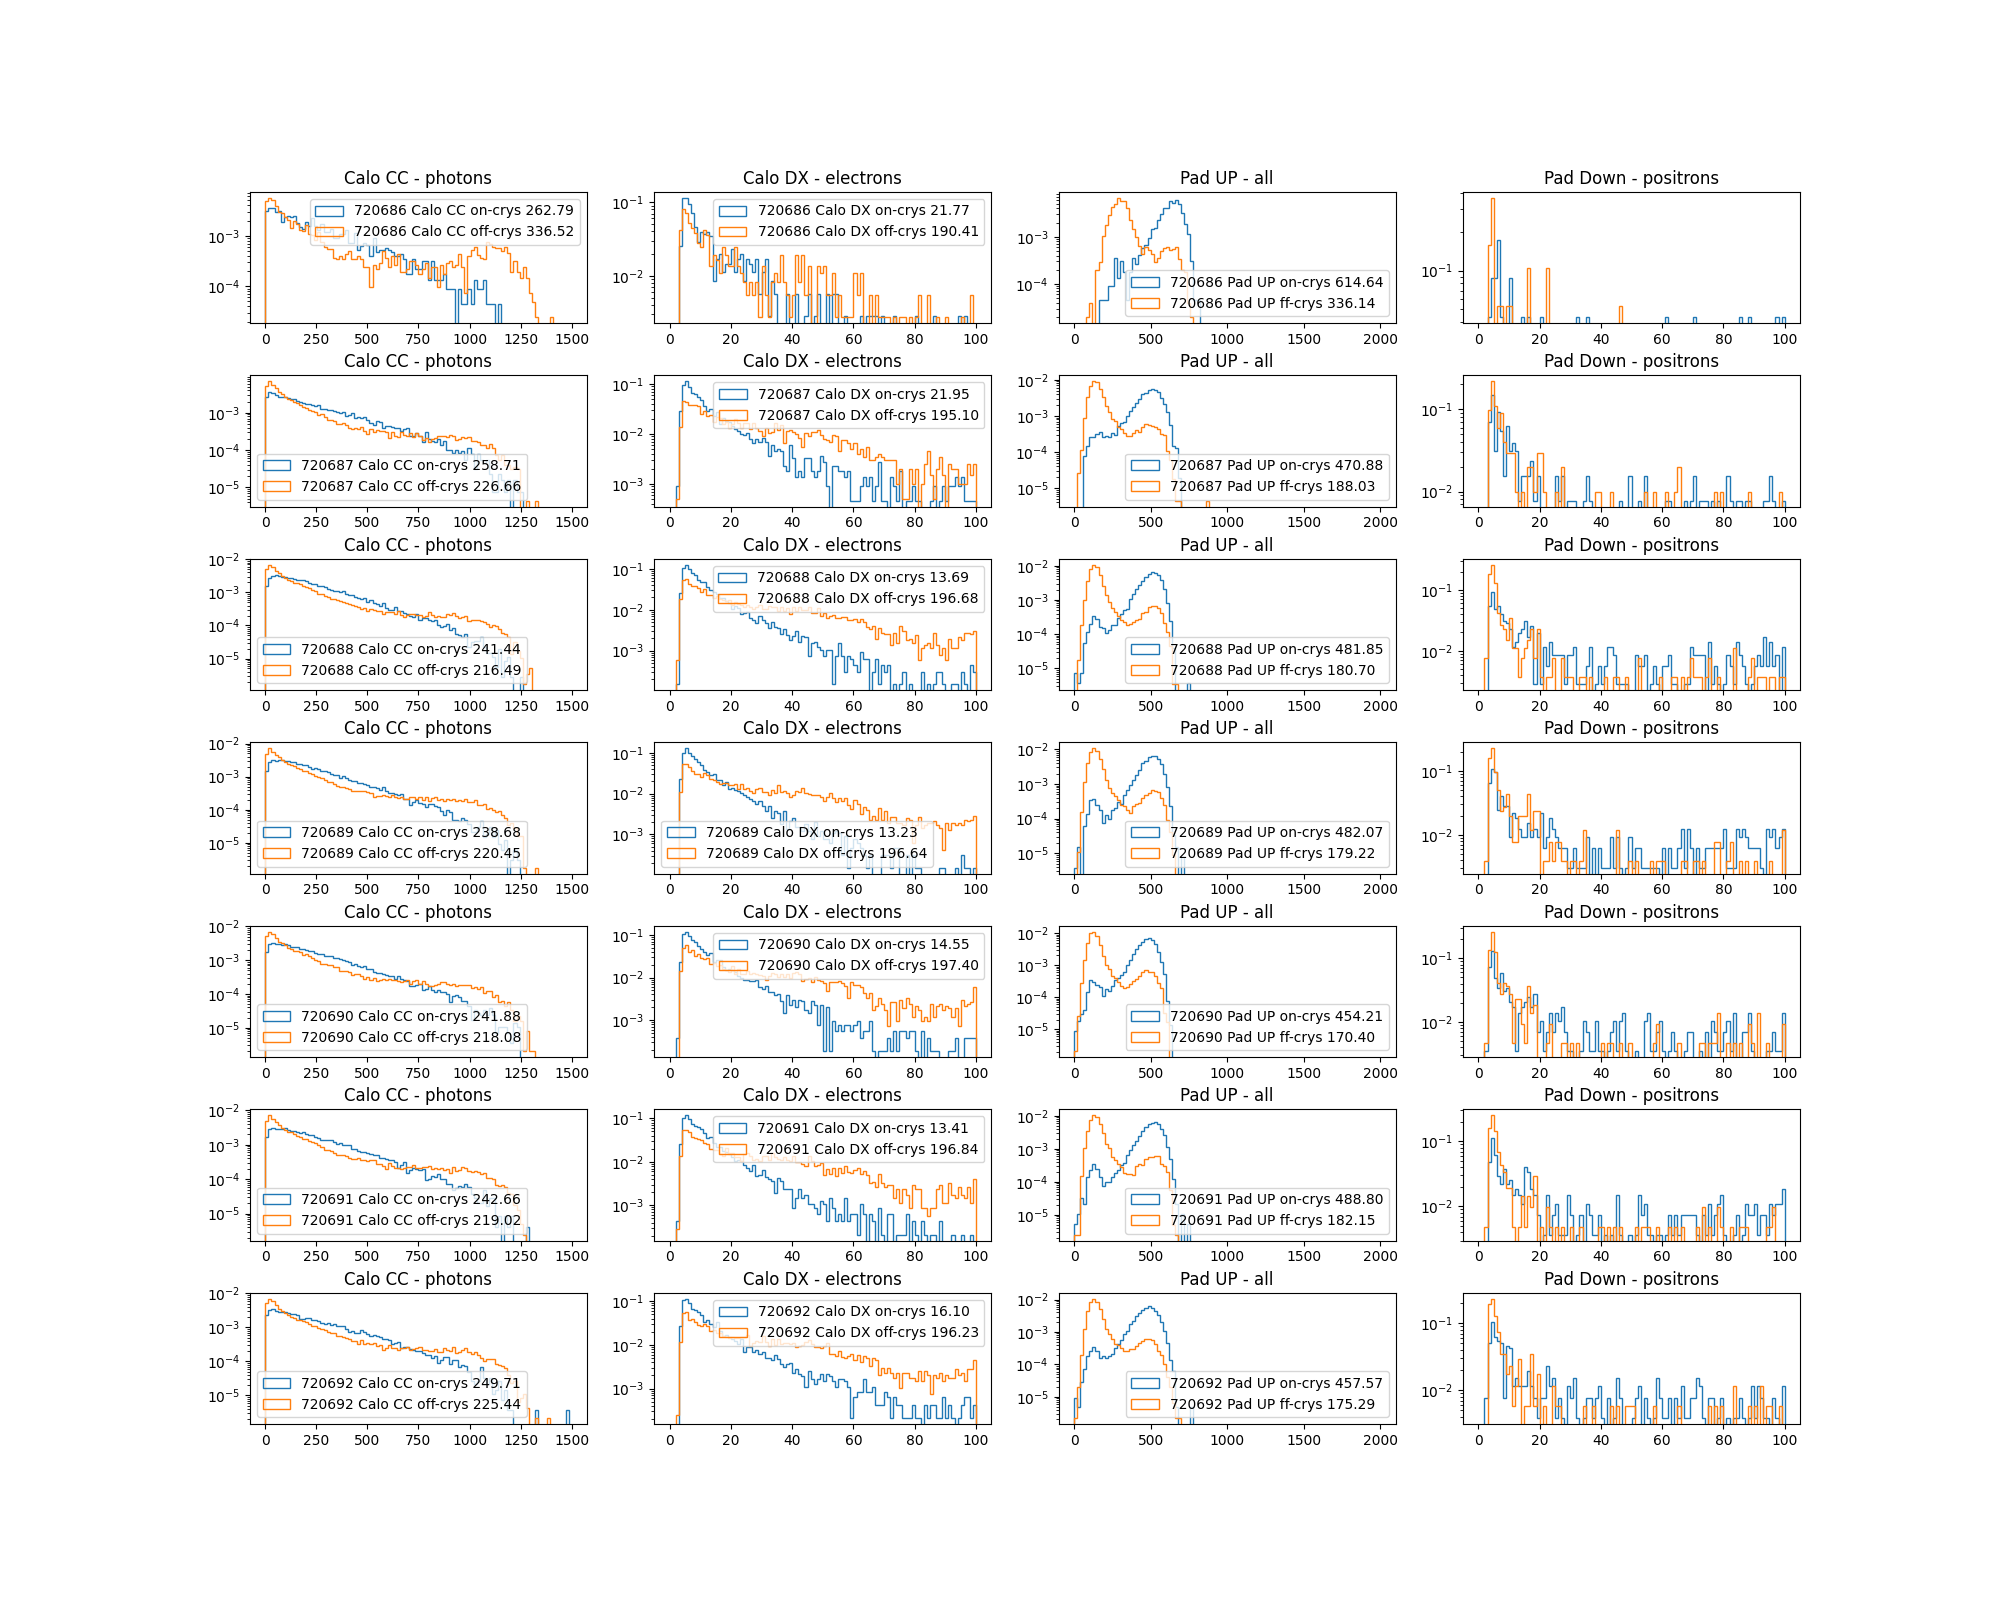

In [8]:
fig, ax = plt.subplots(len(runs) ,4)
fig.set_size_inches(20,16)
fig.subplots_adjust(hspace=.4)

nbins = 100

for i,r in enumerate(runs):
    print(labels[i])
    xpos,xinfo,ph,tm,evi,info_plus,\
    Cherry1,Cherry2,Scinti_desy,Scinti_after_magnet,Calo_photon,Calo_elect1,Calo_elect2,Apc1,Apc2,\
    x1,y1,x2,y2,x_cry,y_cry,theta_in_x,theta_in_y= file_corrector(r)
    theta_in_x = theta_in_x - 2650
    
    # logix = (x2>pos_cut_x[0]) & (x2<pos_cut_x[1])
    # logiy = (y2>pos_cut_y[0]) & (y2<pos_cut_y[1])
    logix = (x_cry>pos_cut_x[0]) & (x_cry<pos_cut_x[1])
    logiy = (y_cry>pos_cut_y[0]) & (y_cry<pos_cut_y[1])
    
    logi_pos = logix & logiy
    logi_cherry = (Cherry1 >21)
    logi_extra = logi_cherry
    
    logi_ph =  (abs((tm[:,2] - tm[:,6]) + 18.5) < 1.5)  ##- 17,-20 
    logi_el =  (abs((tm[:,3] - tm[:,6]) + 18.5) < 1.5)  ##- 17,-20 
    logi_pad_UP =  (abs((tm[:,7] - tm[:,6])) < 2)  ## -2,+2
    logi_pad_DW =  (abs((tm[:,5] - tm[:,6])) < 2)  ## -2,+2
    
    logi_oncryst = logi_pos & logi_extra
    logi_offcryst = [not x for x in logi_pos] & logi_extra
    
    
    mean_ph_oncrys  = np.mean(Calo_photon[logi_oncryst & logi_ph])
    mean_ph_offcrys = np.mean(Calo_photon[logi_offcryst & logi_ph])
    
    mean_e1_oncrys  = np.mean(Calo_elect1[logi_oncryst & logi_el])
    mean_e1_offcrys  = np.mean(Calo_elect1[logi_offcryst & logi_el])
    
    mean_pad_UP_oncrys  = np.mean(Scinti_desy[logi_oncryst & logi_pad_UP])
    mean_pad_UP_offcrys  = np.mean(Scinti_desy[logi_offcryst & logi_pad_UP])
    
    mean_pad_DW_oncrys  = np.mean(Scinti_after_magnet[logi_oncryst & logi_pad_DW])
    mean_pad_DW_offcrys  = np.mean(Scinti_after_magnet[logi_offcryst & logi_pad_DW])
    
    ## CUT ON CRYSTAL
    h_ph_oncrys = ax[i,0].hist(Calo_photon[logi_oncryst & logi_ph], bins = nbins, histtype = 'step', range = (0,1500), label=labels[i] + f' Calo CC on-crys {mean_ph_oncrys:.2f}' , density = True)
    h_e1_oncrys = ax[i,1].hist(Calo_elect1[logi_oncryst & logi_el], bins = nbins, histtype = 'step', range =(0,100),   label=labels[i] + f' Calo DX on-crys {mean_e1_oncrys:.2f}' , density = True)
    h_pad_UP_oncrys = ax[i,2].hist(Scinti_desy[logi_oncryst & logi_pad_UP], bins = nbins, histtype = 'step', range =(0,2000),   label=labels[i] + f' Pad UP on-crys {mean_pad_UP_oncrys:.2f}' , density = True)
    h_pad_DW_oncrys = ax[i,3].hist(Scinti_after_magnet[logi_oncryst & logi_pad_DW], bins = nbins, histtype = 'step', range =(0,100),   label=labels[i] + f' Pad DW on-crys {mean_pad_DW_oncrys:.2f}' , density = True)
    
    binc_h_ph_on = h_ph_oncrys[1][:-1] + (h_ph_oncrys[1][1] - h_ph_oncrys[1][0]) / 2
    binc_h_e1_on = h_e1_oncrys[1][:-1] + (h_e1_oncrys[1][1] - h_e1_oncrys[1][0]) / 2
    binc_h_pad_UP_on = h_pad_UP_oncrys[1][:-1] + (h_pad_UP_oncrys[1][1] - h_pad_UP_oncrys[1][0]) / 2
    binc_h_pad_DW_on = h_pad_DW_oncrys[1][:-1] + (h_pad_DW_oncrys[1][1] - h_pad_DW_oncrys[1][0]) / 2
    
    ## CUT OUT CRYSTAL
    h_ph_offcrys = ax[i,0].hist(Calo_photon[logi_offcryst & logi_ph], bins = nbins, histtype = 'step', range = (0,1500), label=labels[i] + f' Calo CC off-crys {mean_ph_offcrys:.2f}', density = True )
    h_e1_offcrys = ax[i,1].hist(Calo_elect1[logi_offcryst & logi_el], bins = nbins, histtype = 'step', range =(0,100),   label=labels[i] + f' Calo DX off-crys {mean_e1_offcrys:.2f}', density = True)
    h_pad_UP_offcrys = ax[i,2].hist(Scinti_desy[logi_offcryst & logi_pad_UP], bins = nbins, histtype = 'step', range =(0,2000),   label=labels[i] + f' Pad UP ff-crys {mean_pad_UP_offcrys:.2f}' , density = True)
    h_pad_DW_offcrys = ax[i,3].hist(Scinti_after_magnet[logi_offcryst & logi_pad_DW], bins = nbins, histtype = 'step', range =(0,100),   label=labels[i] + f' Pad DW off-crys {mean_pad_DW_offcrys:.2f}' , density = True)
    
    binc_h_ph_off = h_ph_offcrys[1][:-1] + (h_ph_offcrys[1][1] - h_ph_offcrys[1][0]) / 2
    binc_h_e1_off = h_e1_offcrys[1][:-1] + (h_e1_offcrys[1][1] - h_e1_offcrys[1][0]) / 2
    binc_h_pad_UP_off = h_pad_UP_offcrys[1][:-1] + (h_pad_UP_offcrys[1][1] - h_pad_UP_offcrys[1][0]) / 2
    binc_h_pad_DW_off = h_pad_DW_offcrys[1][:-1] + (h_pad_DW_offcrys[1][1] - h_pad_DW_offcrys[1][0]) / 2
    
    
    result_ph_oncrys = h_ph_oncrys[0] * binc_h_ph_on
    result_e1_oncrys = h_e1_oncrys[0] * binc_h_e1_on
    result_pad_UP_oncrys = h_pad_UP_oncrys[0] * binc_h_pad_UP_on
    result_pad_DW_oncrys = h_pad_DW_oncrys[0] * binc_h_pad_DW_on
    
    result_ph_offcrys = h_ph_offcrys[0] * binc_h_ph_off
    result_e1_offcrys = h_e1_offcrys[0] * binc_h_e1_off
    result_pad_UP_offcrys = h_pad_UP_offcrys[0] * binc_h_pad_UP_off
    result_pad_DW_offcrys = h_pad_DW_offcrys[0] * binc_h_pad_DW_off

    
    ax[i,0].legend()
    ax[i,0].set_title('Calo CC - photons')
    ax[i,0].set_yscale('log')
    ax[i,1].legend()
    ax[i,1].set_title('Calo DX - electrons')
    ax[i,1].set_yscale('log')
    ax[i,2].legend()
    ax[i,2].set_title('Pad UP - all')
    ax[i,2].set_yscale('log')
    ax[i,3].set_title('Pad Down - positrons')
    ax[i,3].set_yscale('log')
    print(f' mean ratio ON/OFF : PH {mean_ph_oncrys/mean_ph_offcrys:.2f} E1 {mean_e1_oncrys/mean_e1_offcrys:.2f} PAD UP {mean_pad_UP_oncrys/mean_pad_UP_offcrys:.2f} PAD DW {mean_pad_DW_oncrys/mean_pad_DW_offcrys:.2f}')
    print(f' tot signal ratio ON/OFF : PH {np.sum(result_ph_oncrys)/np.sum(result_ph_offcrys):.2f} E1 {np.sum(result_e1_oncrys)/np.sum(result_e1_offcrys):.2f} PAD UP {np.sum(result_pad_UP_oncrys)/np.sum(result_pad_UP_offcrys):.2f} PAD UP {np.sum(result_pad_DW_oncrys)/np.sum(result_pad_DW_offcrys):.2f}\n')

# fig.text(0.5, 0.9, labels[0], ha='center', fontsize=14)
# fig.text(0.5, 0.62, labels[1], ha='center', fontsize=14)
# fig.text(0.5, 0.36, labels[2], ha='center', fontsize=14)
plt.show()


720686
 mean ratio ON/OFF : PH 0.80 E1 0.15 PAD UP 1.54 PAD DW 1.72
 tot signal ratio ON/OFF : PH 0.45 E1 0.03 PAD UP 1.06 PAD UP 3.43

720687
 mean ratio ON/OFF : PH 1.12 E1 0.15 PAD UP 1.06 PAD DW 1.94
 tot signal ratio ON/OFF : PH 0.65 E1 0.03 PAD UP 3.64 PAD UP 2.10

720688
 mean ratio ON/OFF : PH 1.10 E1 0.11 PAD UP 1.04 PAD DW 1.83
 tot signal ratio ON/OFF : PH 0.65 E1 0.02 PAD UP 4.07 PAD UP 2.69

720689
 mean ratio ON/OFF : PH 1.07 E1 0.10 PAD UP 1.04 PAD DW 2.34
 tot signal ratio ON/OFF : PH 0.64 E1 0.02 PAD UP 4.17 PAD UP 2.62

720690
 mean ratio ON/OFF : PH 1.10 E1 0.11 PAD UP 1.03 PAD DW 1.65
 tot signal ratio ON/OFF : PH 0.65 E1 0.02 PAD UP 4.23 PAD UP 2.25

720691
 mean ratio ON/OFF : PH 1.09 E1 0.10 PAD UP 1.04 PAD DW 2.49
 tot signal ratio ON/OFF : PH 0.65 E1 0.02 PAD UP 4.17 PAD UP 2.86

720692
 mean ratio ON/OFF : PH 1.09 E1 0.12 PAD UP 1.05 PAD DW 1.71
 tot signal ratio ON/OFF : PH 0.64 E1 0.02 PAD UP 4.09 PAD UP 3.10

density False: [384.2231075697211, 270.841704191

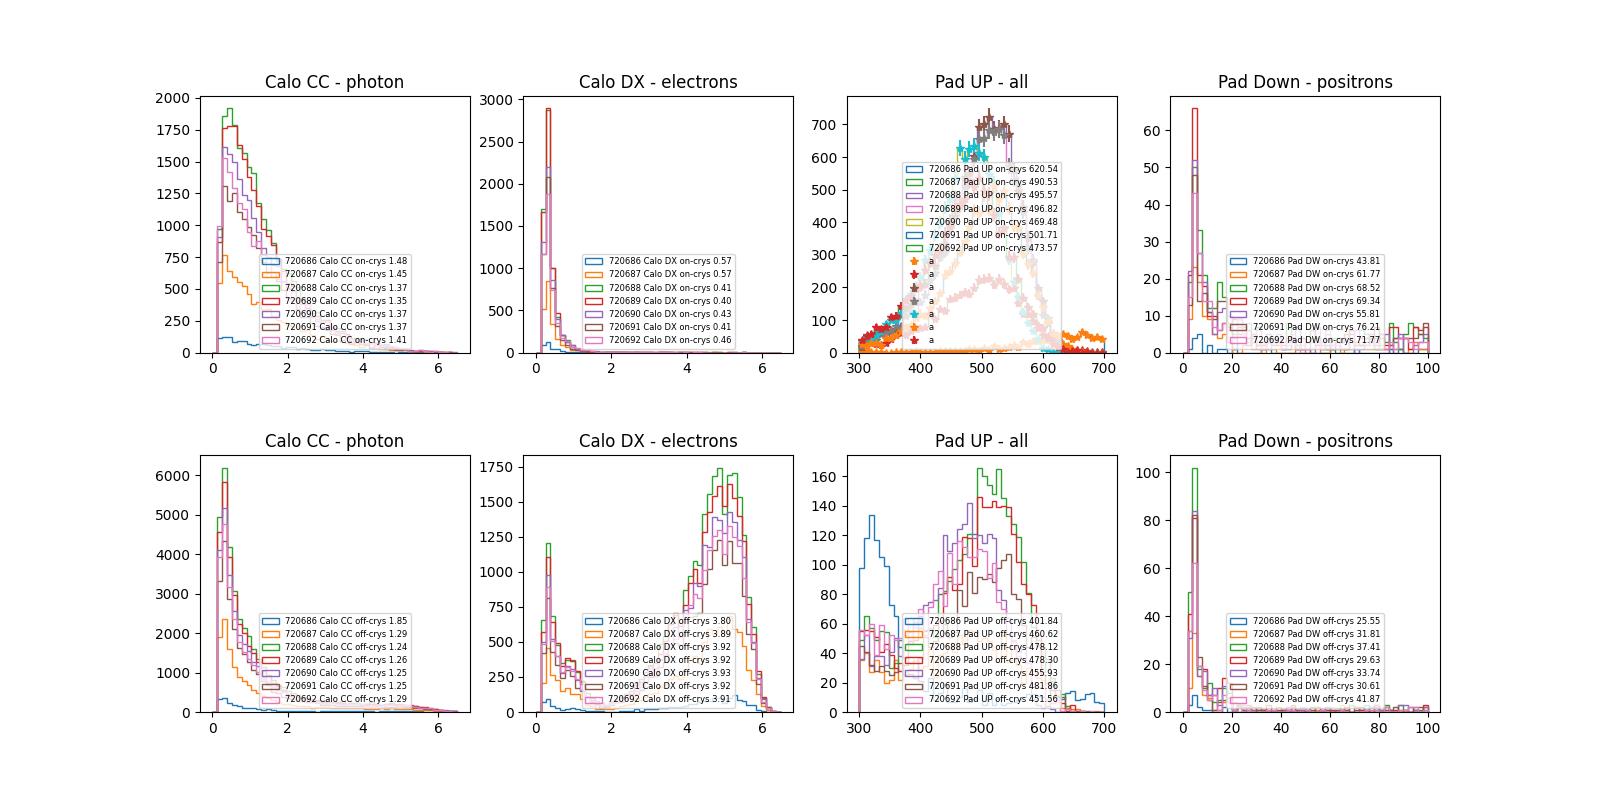

In [9]:
nbins = 50

Calibration = True
show_Off = True
t_density = False

molteplicity =[]
molt_h = []

if show_Off:
    fig, ax = plt.subplots(2,4)
else:
    fig, ax = plt.subplots(2,4)

fig.set_size_inches(16, 8)
fig.subplots_adjust(hspace=.4)

for i,r in enumerate(runs):
    print(labels[i])
    xpos,xinfo,ph,tm,evi,info_plus,\
    Cherry1,Cherry2,Scinti_desy,Scinti_after_magnet,Calo_photon,Calo_elect1,Calo_elect2,Apc1,Apc2,\
    x1,y1,x2,y2,x_cry,y_cry,theta_in_x,theta_in_y= file_corrector(r)
    theta_in_x = theta_in_x - 2650
    if Calibration:
        Calo_photon = (Calo_photon - q)/m
        Calo_elect1 = (Calo_elect1*3.8 - q)/m
        Calo_elect2 = (Calo_elect2*4.2- q)/m

        n_bin_calo = np.arange(0.1,6.5,0.5)  
        calo_th = 0.1
        range_calo = (0,6.5)
        range_caloel1 = (0,6.5)
        range_padUP = (300, 700)
        range_padDW = (0,100)
    else :
        range_calo = (0,1500)
        range_caloel1 = (0,100)
        range_padUP = (0,1500)
        range_padDW = (0,100)

    # logix = (x2>pos_cut_x[0]) & (x2<pos_cut_x[1])
    # logiy = (y2>pos_cut_y[0]) & (y2<pos_cut_y[1])
    logix = (x_cry>pos_cut_x[0]) & (x_cry<pos_cut_x[1])
    logiy = (y_cry>pos_cut_y[0]) & (y_cry<pos_cut_y[1])
    
    logi_pos = logix & logiy
    logi_cherry = (Cherry1 >21)
    logi_extra = logi_cherry
    
    logi_ph =  (abs((tm[:,2] - tm[:,6]) + 18.5) < 1.5)  ##- 17,-20 
    logi_el =  (abs((tm[:,3] - tm[:,6]) + 18.5) < 1.5)  ##- 17,-20 
    logi_pad_UP_tm =  (abs((tm[:,7] - tm[:,6])) < 2)  ## -2,+2
    logi_pad_UP = (Scinti_desy>300) & logi_pad_UP_tm
    logi_pad_DW =  (abs((tm[:,5] - tm[:,6])) < 2)  ## -2,+2
    
    logi_oncryst = logi_pos & logi_extra
    logi_offcryst = [not x for x in logi_pos] & logi_extra
    
    mean_ph_oncrys  = np.mean(Calo_photon[logi_oncryst & logi_ph])
    mean_ph_offcrys = np.mean(Calo_photon[logi_offcryst & logi_ph])
    
    mean_e1_oncrys  = np.mean(Calo_elect1[logi_oncryst & logi_el])
    mean_e1_offcrys  = np.mean(Calo_elect1[logi_offcryst & logi_el])
    
    mean_pad_UP_oncrys  = np.mean(Scinti_desy[logi_oncryst & logi_pad_UP])
    mean_pad_UP_offcrys  = np.mean(Scinti_desy[logi_offcryst & logi_pad_UP])
    
    mean_pad_DW_oncrys  = np.mean(Scinti_after_magnet[logi_oncryst & logi_pad_DW])
    mean_pad_DW_offcrys  = np.mean(Scinti_after_magnet[logi_offcryst & logi_pad_DW])
    
    ## CUT ON CRYSTAL
    
    h_ph_oncrys = ax[0,0].hist(Calo_photon[logi_oncryst & logi_ph], bins = nbins, histtype = 'step', range = range_calo, label=labels[i] + f' Calo CC on-crys {mean_ph_oncrys:.2f}' , density = t_density)
    h_e1_oncrys = ax[0,1].hist(Calo_elect1[logi_oncryst & logi_el], bins = nbins, histtype = 'step', range = range_caloel1,   label=labels[i] + f' Calo DX on-crys {mean_e1_oncrys:.2f}' , density = t_density)
    h_pad_UP_oncrys = ax[0,2].hist(Scinti_desy[logi_oncryst & logi_pad_UP], bins = nbins, histtype = 'step', range = range_padUP,   label=labels[i] + f' Pad UP on-crys {mean_pad_UP_oncrys:.2f}' , density = t_density)


    h_pad_DW_oncrys = ax[0,3].hist(Scinti_after_magnet[logi_oncryst & logi_pad_DW], bins = nbins, histtype = 'step', range =range_padDW,   label=labels[i] + f' Pad DW on-crys {mean_pad_DW_oncrys:.2f}' , density = t_density)
    
    binc_h_ph_on = h_ph_oncrys[1][:-1] + (h_ph_oncrys[1][1] - h_ph_oncrys[1][0]) / 2
    binc_h_e1_on = h_e1_oncrys[1][:-1] + (h_e1_oncrys[1][1] - h_e1_oncrys[1][0]) / 2
    binc_h_pad_UP_on = h_pad_UP_oncrys[1][:-1] + (h_pad_UP_oncrys[1][1] - h_pad_UP_oncrys[1][0]) / 2
    binc_h_pad_DW_on = h_pad_DW_oncrys[1][:-1] + (h_pad_DW_oncrys[1][1] - h_pad_DW_oncrys[1][0]) / 2

    result_ph_oncrys = h_ph_oncrys[0] * binc_h_ph_on
    result_e1_oncrys = h_e1_oncrys[0] * binc_h_e1_on
    result_pad_UP_oncrys = h_pad_UP_oncrys[0] * binc_h_pad_UP_on
    result_pad_DW_oncrys = h_pad_DW_oncrys[0] * binc_h_pad_DW_on

    ax[0,2].errorbar(binc_h_pad_UP_on, h_pad_UP_oncrys[0], yerr = np.sqrt(h_pad_UP_oncrys[0]), ls = "", marker = "*", label = "a")
    # if t_density:         molt_h.append(binc_h_pad_UP_on[np.argmax(h_pad_UP_oncrys[0])]) 
    if t_density:           molt_h.append(np.max(h_pad_UP_oncrys[0])) 
    else:   molteplicity.append(np.sum(result_pad_UP_oncrys)/np.sum(h_ph_oncrys[0]))    
    if show_Off:
    ## CUT OUT CRYSTAL
        h_ph_offcrys = ax[1,0].hist(Calo_photon[logi_offcryst & logi_ph], bins = nbins, histtype = 'step', range = range_calo, label=labels[i] + f' Calo CC off-crys {mean_ph_offcrys:.2f}', density = t_density )
        h_e1_offcrys = ax[1,1].hist(Calo_elect1[logi_offcryst & logi_el], bins = nbins, histtype = 'step', range =range_caloel1,   label=labels[i] + f' Calo DX off-crys {mean_e1_offcrys:.2f}', density = t_density)
        h_pad_UP_offcrys = ax[1,2].hist(Scinti_desy[logi_offcryst & logi_pad_UP], bins = nbins, histtype = 'step', range =range_padUP,   label=labels[i] + f' Pad UP off-crys {mean_pad_UP_offcrys:.2f}' , density = t_density)
        h_pad_DW_offcrys = ax[1,3].hist(Scinti_after_magnet[logi_offcryst & logi_pad_DW], bins = nbins, histtype = 'step', range =range_padDW,   label=labels[i] + f' Pad DW off-crys {mean_pad_DW_offcrys:.2f}' , density = t_density)
        
        binc_h_ph_off = h_ph_offcrys[1][:-1] + (h_ph_offcrys[1][1] - h_ph_offcrys[1][0]) / 2
        binc_h_e1_off = h_e1_offcrys[1][:-1] + (h_e1_offcrys[1][1] - h_e1_offcrys[1][0]) / 2
        binc_h_pad_UP_off = h_pad_UP_offcrys[1][:-1] + (h_pad_UP_offcrys[1][1] - h_pad_UP_offcrys[1][0]) / 2
        binc_h_pad_DW_off = h_pad_DW_offcrys[1][:-1] + (h_pad_DW_offcrys[1][1] - h_pad_DW_offcrys[1][0]) / 2
        
        result_ph_offcrys = h_ph_offcrys[0] * binc_h_ph_off
        result_e1_offcrys = h_e1_offcrys[0] * binc_h_e1_off
        result_pad_UP_offcrys = h_pad_UP_offcrys[0] * binc_h_pad_UP_off
        result_pad_DW_offcrys = h_pad_DW_offcrys[0] * binc_h_pad_DW_off
        
       
        
        print(f' mean ratio ON/OFF : PH {mean_ph_oncrys/mean_ph_offcrys:.2f} E1 {mean_e1_oncrys/mean_e1_offcrys:.2f} PAD UP {mean_pad_UP_oncrys/mean_pad_UP_offcrys:.2f} PAD DW {mean_pad_DW_oncrys/mean_pad_DW_offcrys:.2f}')
        print(f' tot signal ratio ON/OFF : PH {np.sum(result_ph_oncrys)/np.sum(result_ph_offcrys):.2f} E1 {np.sum(result_e1_oncrys)/np.sum(result_e1_offcrys):.2f} PAD UP {np.sum(result_pad_UP_oncrys)/np.sum(result_pad_UP_offcrys):.2f} PAD UP {np.sum(result_pad_DW_oncrys)/np.sum(result_pad_DW_offcrys):.2f}\n')
    # else:
    #     ax[1,0].remove()
    #     ax[1,1].remove()
    #     ax[1,2].remove()
    #     ax[1,3].remove()
if t_density:        
    print(f'density {t_density}: {molt_h}')
    if len(runs) == 2:
        print(f'ratio {molt_h[0]/molt_h[1]:.3f}')
else:        
    print(f'density {t_density}: {molteplicity}')
    if len(runs) == 2:
        print(f'ratio {molteplicity[0]/molteplicity[1]:.3f}')
    
ax[0,0].set_title('Calo CC - photon')
ax[0,1].set_title('Calo DX - electrons')
ax[0,2].set_title('Pad UP - all')
ax[0,3].set_title('Pad Down - positrons')
ax[1,0].set_title('Calo CC - photon')
ax[1,1].set_title('Calo DX - electrons')
ax[1,2].set_title('Pad UP - all')
ax[1,3].set_title('Pad Down - positrons')
    
axi = ax.flatten()
for a in axi:
    a.legend(fontsize = 6, loc = "lower center")
    # a.set_yscale('log') 
plt.show()

In [10]:
# (molt_h[0]-molt_h[2])/molt_h[0]
if t_density:
    for i,m in enumerate(molt_h):
        print(labels[i],'/ax \t', 100*(molt_h[0]-m)/molt_h[0])
else:
    for i,m in enumerate(molteplicity):
        print(labels[i],'/ax \t', 100*(molteplicity[0]-m)/molteplicity[0])

720686 /ax 	 0.0
720687 /ax 	 29.50926197429315
720688 /ax 	 27.523125780458102
720689 /ax 	 27.468070996505915
720690 /ax 	 31.424491179222738
720691 /ax 	 26.541780889307635
720692 /ax 	 31.332116977623592


720686
720687
720688
720689
720690
720691
720692
density True: [0.008368200836820083, 0.005966087502616705, 0.0068872885230909925, 0.006910307035216375, 0.00730347433416275, 0.0070861992456179275, 0.006720160481444333]


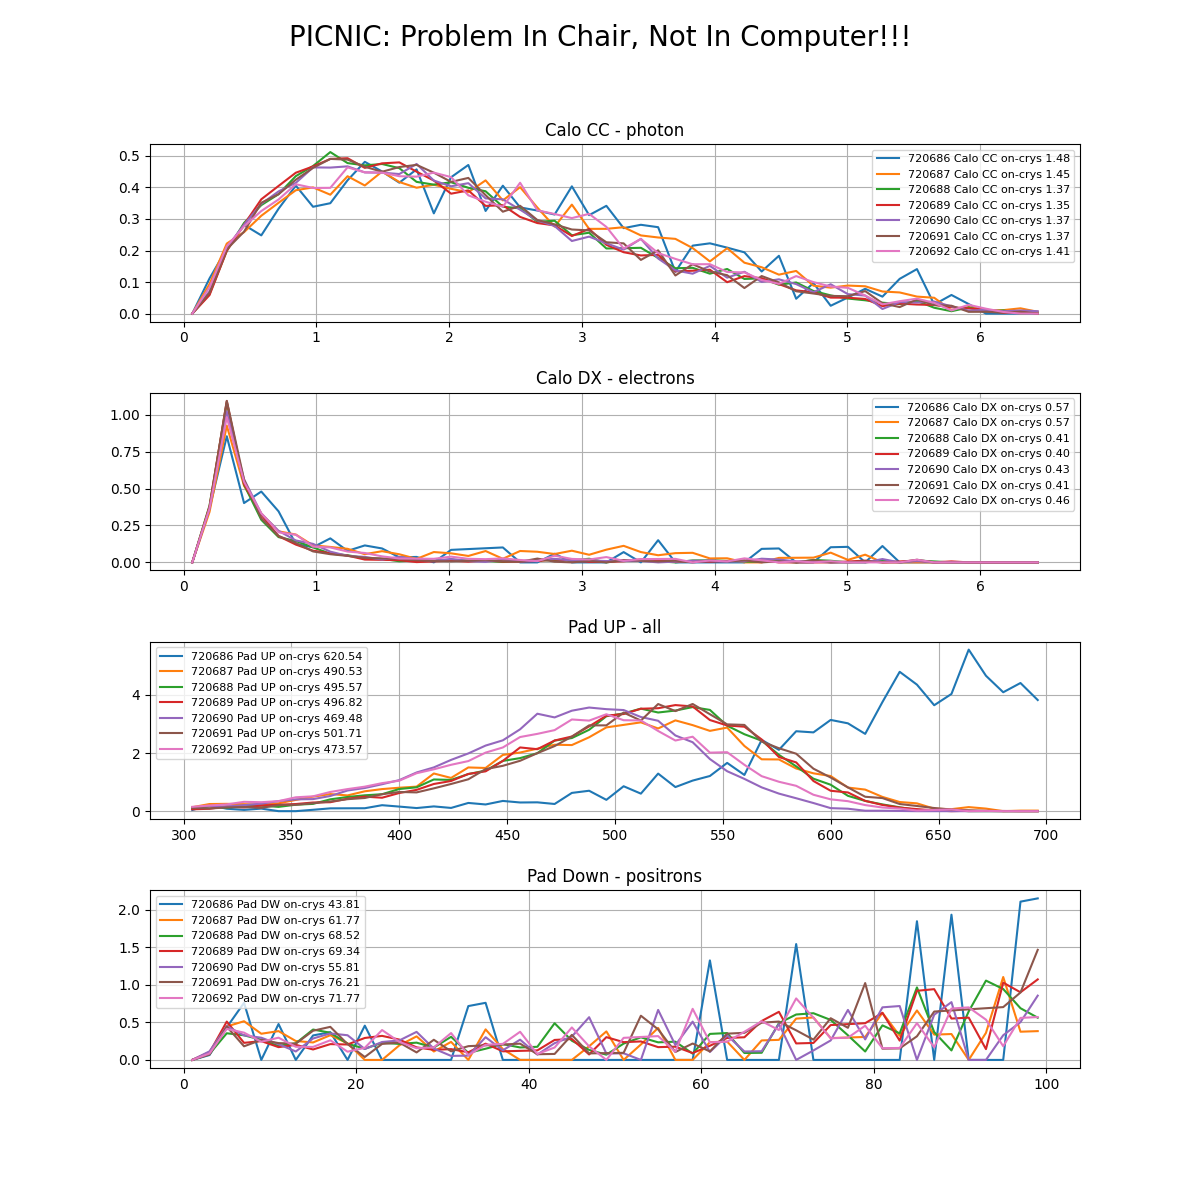

In [11]:
%matplotlib widget
dizi, mycmap = configurator(year,material,Swan_h)

m = dizi['slope_Calo']
q = dizi['intercept_Calo']

nbins = 50

Calibration = True
show_Off = True
t_density = True

molteplicity =[]
molt_h = []

fig, ax = plt.subplots(4,1)
fig.set_size_inches(12,12)
fig.subplots_adjust(hspace=.4)
fig.suptitle("PICNIC: Problem In Chair, Not In Computer!!!", fontsize = 20)

for i,r in enumerate(runs):
    print(labels[i])
    xpos,xinfo,ph,tm,evi,info_plus,\
    Cherry1,Cherry2,Scinti_desy,Scinti_after_magnet,Calo_photon,Calo_elect1,Calo_elect2,Apc1,Apc2,\
    x1,y1,x2,y2,x_cry,y_cry,theta_in_x,theta_in_y= file_corrector(r)
    theta_in_x = theta_in_x - 2650
    if Calibration:
        Calo_photon = (Calo_photon - q)/m
        Calo_elect1 = (Calo_elect1*3.8 - q)/m
        Calo_elect2 = (Calo_elect2*4.2- q)/m

        n_bin_calo = np.arange(0.1,6.5,0.5)  
        calo_th = 0.1
        range_calo = (0,6.5)
        range_caloel1 = (0,6.5)
        range_padUP = (300, 700)
        range_padDW = (0,100)
    else :
        range_calo = (0,1500)
        range_caloel1 = (0,100)
        range_padUP = (0,1500)
        range_padDW = (0,100)

    # logix = (x2>pos_cut_x[0]) & (x2<pos_cut_x[1])
    # logiy = (y2>pos_cut_y[0]) & (y2<pos_cut_y[1])
    logix = (x_cry>pos_cut_x[0]) & (x_cry<pos_cut_x[1])
    logiy = (y_cry>pos_cut_y[0]) & (y_cry<pos_cut_y[1])
    
    logi_pos = logix & logiy
    logi_cherry = (Cherry1 >21)
    logi_extra = logi_cherry
    
    logi_ph =  (abs((tm[:,2] - tm[:,6]) + 18.5) < 1.5)  ##- 17,-20 
    logi_el =  (abs((tm[:,3] - tm[:,6]) + 18.5) < 1.5)  ##- 17,-20 
    logi_pad_UP_tm =  (abs((tm[:,7] - tm[:,6])) < 2)  ## -2,+2
    logi_pad_UP = (Scinti_desy>300) & logi_pad_UP_tm
    logi_pad_DW =  (abs((tm[:,5] - tm[:,6])) < 2)  ## -2,+2
    
    logi_oncryst = logi_pos & logi_extra
    logi_offcryst = [not x for x in logi_pos] & logi_extra
    
    mean_ph_oncrys  = np.mean(Calo_photon[logi_oncryst & logi_ph])
    mean_ph_offcrys = np.mean(Calo_photon[logi_offcryst & logi_ph])
    
    mean_e1_oncrys  = np.mean(Calo_elect1[logi_oncryst & logi_el])
    mean_e1_offcrys  = np.mean(Calo_elect1[logi_offcryst & logi_el])
    
    mean_pad_UP_oncrys  = np.mean(Scinti_desy[logi_oncryst & logi_pad_UP])
    mean_pad_UP_offcrys  = np.mean(Scinti_desy[logi_offcryst & logi_pad_UP])
    
    mean_pad_DW_oncrys  = np.mean(Scinti_after_magnet[logi_oncryst & logi_pad_DW])
    mean_pad_DW_offcrys  = np.mean(Scinti_after_magnet[logi_offcryst & logi_pad_DW])
    
    ## CUT ON CRYSTAL
    
    h_ph_oncrys = np.histogram(Calo_photon[logi_oncryst & logi_ph],range = range_calo , bins = nbins,  density = t_density)
    h_e1_oncrys = np.histogram(Calo_elect1[logi_oncryst & logi_el],range = range_caloel1 , bins = nbins,    density = t_density)
    h_pad_UP_oncrys = np.histogram(Scinti_desy[logi_oncryst & logi_pad_UP],range = range_padUP , bins = nbins,  density = t_density)
    h_pad_DW_oncrys = np.histogram(Scinti_after_magnet[logi_oncryst & logi_pad_DW],range = range_padDW , bins = nbins,  density = t_density)
   
    binc_h_ph_on = h_ph_oncrys[1][:-1] + (h_ph_oncrys[1][1] - h_ph_oncrys[1][0]) / 2
    binc_h_e1_on = h_e1_oncrys[1][:-1] + (h_e1_oncrys[1][1] - h_e1_oncrys[1][0]) / 2
    binc_h_pad_UP_on = h_pad_UP_oncrys[1][:-1] + (h_pad_UP_oncrys[1][1] - h_pad_UP_oncrys[1][0]) / 2
    binc_h_pad_DW_on = h_pad_DW_oncrys[1][:-1] + (h_pad_DW_oncrys[1][1] - h_pad_DW_oncrys[1][0]) / 2

    result_ph_oncrys = h_ph_oncrys[0] * binc_h_ph_on
    result_e1_oncrys = h_e1_oncrys[0] * binc_h_e1_on
    result_pad_UP_oncrys = h_pad_UP_oncrys[0] * binc_h_pad_UP_on
    result_pad_DW_oncrys = h_pad_DW_oncrys[0] * binc_h_pad_DW_on
    # if t_density:         molt_h.append(binc_h_pad_UP_on[np.argmax(h_pad_UP_oncrys[0])]) 
    ax[0].plot(binc_h_ph_on,result_ph_oncrys,label=labels[i] + f' Calo CC on-crys {mean_ph_oncrys:.2f}' )
    ax[1].plot(binc_h_e1_on,result_e1_oncrys,label=labels[i] + f' Calo DX on-crys {mean_e1_oncrys:.2f}' )
    ax[2].plot(binc_h_pad_UP_on,result_pad_UP_oncrys,label=labels[i] + f' Pad UP on-crys {mean_pad_UP_oncrys:.2f}' )
    ax[3].plot(binc_h_pad_DW_on,result_pad_DW_oncrys,label=labels[i] + f' Pad DW on-crys {mean_pad_DW_oncrys:.2f}' )

    if t_density:           molt_h.append(np.max(h_pad_UP_oncrys[0])) 
    else:   molteplicity.append(np.sum(result_pad_UP_oncrys)/np.sum(h_ph_oncrys[0]))    
        
if t_density:        
    print(f'density {t_density}: {molt_h}')
    if len(runs) == 2:
        print(f'ratio {molt_h[0]/molt_h[1]:.3f}')
else:        
    print(f'density {t_density}: {molteplicity}')
    if len(runs) == 2:
        print(f'ratio {molteplicity[0]/molteplicity[1]:.3f}')
    
ax[0].set_title('Calo CC - photon')
ax[1].set_title('Calo DX - electrons')
ax[2].set_title('Pad UP - all')
ax[3].set_title('Pad Down - positrons')
    
axi = ax.flatten()
for a in axi:
    a.legend(fontsize = 8)
    # a.set_yscale('log') 
    a.grid()
plt.show()


In [12]:
Calo_photon.shape

(70627,)

In [13]:
range_calo

(0, 6.5)

In [14]:
def gaussian_fit(hist, bins,arg):
    # Calculate bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Initial guess for the parameters
    initial_guess = [max(hist), bin_centers[np.argmax(hist)], np.std(arg)]
    
    # Fit the Gaussian model to the data
    params, _ = curve_fit(myGauss, bin_centers, hist, p0=initial_guess)
    
    # Create fitted data points
    x_fit = np.linspace(bins[0], bins[-1], 100)
    y_fit = myGauss(x_fit, *params)
    
    return params, x_fit, y_fit

720790
(5644,)
720792
(3328,)
720793
(5243,)


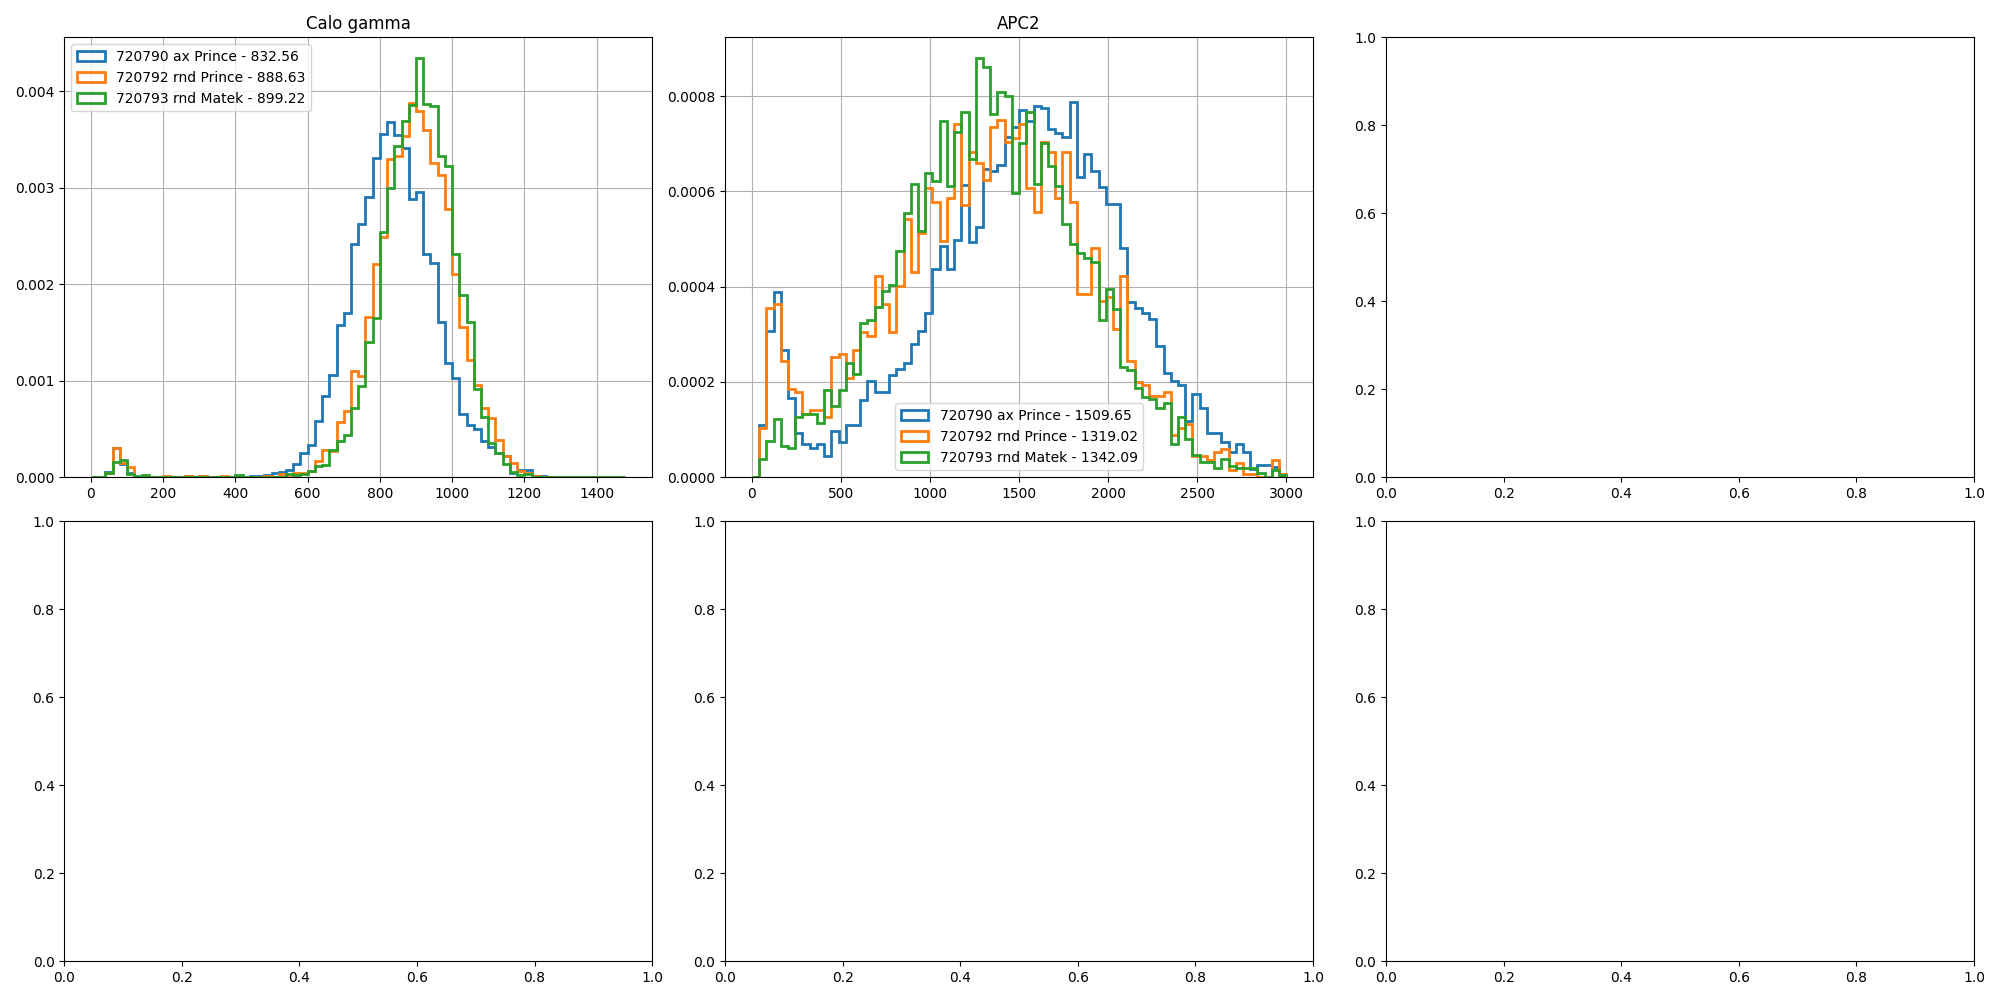

In [15]:

###### PRINCE 10 MM RICERCA ASSE #########
# run_scan = [720746    ,720745    ,720747    ,720748    ,720749   , 720750  , 720751   ,720752  , 720753]#,720730]#]
# labels = ['rnd '      ,'-30 c'   ,'+30 c'   ,'-20 c'   ,'+20 r'  ,'-20 r'  , '+40 r'  , '+10 r', '+6 c' ]#,'+30 mrad']#,] 
# ev_lim =['ok'         ,'ok'      ,140000    ,'ok'      ,'ok'     ,'ok'     , 'ok'     , 'ok'  , 'ok']

Crad_scan = False #False
Rot_scan = False #True
Full_stereo = False
if Full_stereo:
    run_scan = [720746    ,720749   , 720750  , 720751   , 720753, 720771, 720772,   720774 ,  720775    ,  720778 , 720779, 720776     ]
    labels = ['rnd '      ,'+20 r'  ,'-20 r'  , '+40 r'  , '+6 c', '-40 r','-60 r'   ,   '-30 c' ,  '+15 c'   ,  '-45 c', '-70' ,'+33c LOW STAT'    ] 
    ev_lim = ['ok'        ,'ok'     ,'ok'     , 'ok'      , 'ok'  , 'ok', 'ok', 'ok'  ,    'ok'    ,  'ok'   , 'ok'  ,'ok'  ]
if Rot_scan:
    run_scan = [720746    ,720749   , 720750  , 720751   , 720753, 720771, 720772]
    labels = ['rnd '      ,'+20 r'  ,'-20 r'  , '+40 r'  , '+6 c', '-40 r','-60 r'] 
    ev_lim = ['ok'        ,'ok'     ,'ok'     , 'ok'      , 'ok'  , 'ok', 'ok']
elif Crad_scan:
    # run_scan = [720746    ,720745    ,720747    ,720748    , 720753]
    # labels = ['rnd '      ,'-30 c'   ,'+30 c'   ,'-20 c'   , '+6 c'] 
    # ev_lim = ['ok'        ,'ok'      ,140000    ,'ok'      , 'ok' ]
    run_scan = [720746    ,    720774 ,  720775    ,  720778 , 720779, 720776    ]
    labels =   ['rnd '    ,   '-30 c' ,  '+15 c'   ,  '-45 c', '-70' ,'+33c LOW STAT'    ] 
    ev_lim =   ['ok'      ,     'ok'  ,    'ok'    ,  'ok'   , 'ok'  ,'ok'    ]

# ##### Matek 1.5 mm + 8.5mm amorfo  #########
# run_scan = [720760,720768,720770,720754,720756,720756]#,720734,720739,720699]
# labels   = ['rnd' ,'rnd' ,'rnd' ,'rnd' ,'rnd' ,'rnd' ]#,'+30 mrad']#,] 
# ev_lim   = ['ok'        ,'ok'     ,'ok'     , 'ok'      , 'ok'  , 'ok']


# run_scan = [    720770   ,       720760]
# labels   = [  'rnd Mag off', 'rnd Mag on'] 
# ev_lim   = [  'ok'       ,   35000     ] # , 20000 ,140000,

# run_scan = [[720734,720739], 720765 ,[720754,720757],[720756,720760]]
# labels   = [      'ax at open'     , 'ax'   ,      'rnd 1 '    ,     'rnd 2'     ] 
# ev_lim   = [      'ok'     ,  'ok'  ,      120000   ,     20000     ] # , 20000 ,140000,

# Matek_1_5 = { 
#     720754 : 'rnd' , 125000,
#     720756 : 'rnd' , 30000,
#     720757 : 'rnd' , 35000,
#     720734 : 'ax' , 140000,
#     720739 : 'ax' , 'ok',
#     720699 : 'ax' , 'ok', #different config
#     720700 : 'ax' , 'ok', #different config

# }
###############################################

# run_scan = [720746    ,720729   ,720749   , 720750]#,720730]#]
# labels = ['amorphous ','+6 crad','+20 rot','-20 rot']#,'+30 mrad']#,] 
# ev_lim =['ok'         ,'ok'     ,'ok'     ,'ok']

run_scan = [720790 , 720792, 720793]
labels = ['ax Prince', 'rnd Prince', 'rnd Matek']
ev_lim = ['ok', 'ok', 'ok']

time_index = [2,7] ##lG C and Padella UP
Calibration = False

t_density = True

fig, ax = plt.subplots(2,3)
fig.set_size_inches(20, 10)
ax = ax.flatten()


opt = {"histtype": 'step', "density" : t_density, 'lw': 2}
mean_calo, mean_el1 ,mean_el2,= [], [], [] 
mean_desy, mean_apc2, mean_positron = [], [], []

bin_apc2 = np.linspace(0,3000,75)
# bin_apc2 = np.linspace(0,1500,75)
bin_e1 = np.linspace(0,400,50)
bin_e2 = np.linspace(0,400,30)
bin_positron = np.linspace(0,10000,30)
bin_desy = np.linspace(0,1000,50)

for i, r in enumerate(run_scan):
    print(r)
    xpos,xinfo,ph,tm,evi,info_plus,\
    ph_cherry1,ph_cherry2,ph_scinti_desy,ph_scinti_after_magnet,ph_calo_photon,ph_calo_elect1,ph_calo_elect2,ph_apc1,ph_apc2,\
    x1,y1,x2,y2,x_cry,y_cry,theta_in_x,theta_in_y = file_corrector(r)
    theta_in_x = theta_in_x - 2000
    
    if ev_lim[i] != 'ok':
        logi_ev = evi <  ev_lim[i]
    else : 
        logi_ev = evi <  np.max(evi)

    logix = (x2>pos_cut_x[0]) & (x2<pos_cut_x[1])
    logiy = (y2>pos_cut_y[0]) & (y2<pos_cut_y[1])

    logi_pos = logix & logiy
    logi_cherry = ph_cherry1 >21
    
    logi_time_calo = ((tm[:,2]-tm[:,6]) < -20 ) & (tm[:,2]-(tm[:,6]) > -22)
    logi_calo = (ph_calo_photon > calo_th) & logi_time_calo
    
    logi_e1 = (ph_calo_elect1 > 50) 
    logi_e2 = (ph_calo_elect2 > 50) 

    logi_positron = ph_scinti_after_magnet > 2500
    
    logi_scinti = (ph_scinti_desy > 100)
    
    logi_angle = ((theta_in_x)**2 + (theta_in_y)**2) < (3000)**2
    
    logi_pad_UP_tm =  (abs((tm[:,7] - tm[:,6])) < 2)  ## -2,+2
    logi_pad_UP = (ph_scinti_desy>300) & logi_pad_UP_tm
    
    logi_apc2_time = ((tm[:,1]-tm[:,6]) < -22 ) & ((tm[:,1]-tm[:,6]) > -24)
    logi_apc2 = (ph_apc2>50) & logi_apc2_time
    
    if Calibration:
        calo_th = 0.1 #GeV
        ph_calo_photon = (ph_calo_photon - q)/m
        logi_calo = (ph_calo_photon > calo_th)
        bin_calo = np.arange(0,6.5,0.2)
        # logi = logi_pos & logi_calo & logi_cherry & logi_time ## & logi_angle
        # logi = logi_calo & logi_ev & logi_cherry & logi_time_calo & logi_pad_UP
        logi = logi_calo & logi_ev & logi_cherry & logi_time_calo
    else: 
        calo_th = 10 #ADC
        logi_calo = (ph_calo_photon > calo_th)
        # logi = logi_calo & logi_pos
        # logi = logi_calo & logi_ev & logi_cherry & logi_time_calo & logi_pad_UP
        logi = logi_calo & logi_ev & logi_cherry & logi_time_calo 
        # bin_calo = np.arange(0,np.max(ph_calo_photon),20)
        bin_calo = np.arange(0,1500,20)
    
    logi = logi & logi_pos

    ax[0].set_title('Calo gamma')
    h_calo = ax[0].hist(ph_calo_photon[logi],bins = bin_calo, label = f'{r} {labels[i]} - {np.mean(ph_calo_photon[logi]):.2f}', **opt)
    mean_calo.append(np.mean(ph_calo_photon[logi]))
    np.shape(ph_calo_photon[logi])
    
    # ax[1].set_title('Calo e1 DX')
    # h_el1 = ax[1].hist(ph_calo_elect1[logi& logi_e1],bins = bin_e1, label = f'{r} {labels[i]} - {np.mean(ph_calo_elect1[logi& logi_e1]):.2f}', **opt)
    # mean_el1.append(np.mean(ph_calo_elect1[logi& logi_e1]))

    ax[1].set_title('APC2')
    h_apc2 = ax[1].hist(ph_apc2[logi & logi_apc2],bins = bin_apc2, label = f'{r} {labels[i]} - {np.mean(ph_apc2[logi & logi_apc2]):.2f}', **opt)
    mean_desy.append(np.mean(ph_apc2[logi & logi_apc2]))
    print(np.shape(ph_apc2[logi & logi_apc2]))
                     
    
    # ax[4].set_title('Calo e2 DXDX')
    # h_el2 = ax[4].hist(ph_calo_elect2[logi& logi_e2],bins = bin_e2, label = f'{r} {labels[i]} - {np.mean(ph_calo_elect2[logi& logi_e2]):.2f}', **opt)
    # mean_desy.append(np.mean(ph_scinti_desy[logi& logi_e2]))
                     
    # ax[3].set_title('scinti desy')
    # h_desy = ax[3].hist(ph_scinti_desy[logi & logi_pad_UP],bins = bin_desy, label = f'{r} {labels[i]} - {np.mean(ph_scinti_desy[logi & logi_pad_UP]):.2f}', **opt)
    # mean_desy.append(np.mean(ph_scinti_desy[logi]))
    # params, x_fit, y_fit = gaussian_fit (h_desy[0], h_desy[1],ph_scinti_desy[logi & logi_pad_UP])
    # # print(params[2])
    # ax[3].plot(x_fit,y_fit, c = 'k', ls = '--')
                     

    # ax[5].set_title('Canadese positroni')
    # h_positron = ax[5].hist(ph_scinti_after_magnet[logi & logi_positron],bins = bin_positron, label = f'{r} {labels[i]} - {np.mean(ph_scinti_after_magnet[logi & logi_positron]):.2f}', **opt)
    # mean_positron.append(np.mean(ph_scinti_after_magnet[logi & logi_positron]))
                     
                     

# for a in ax:
for a in (ax[0],ax[1]):
    a.grid()
    a.legend()
    # a.set_yscale('log')
    
plt.tight_layout()
plt.show()

In [ ]:

###### PRINCE 10 MM RICERCA ASSE #########
# run_scan = [720746    ,720745    ,720747    ,720748    ,720749   , 720750  , 720751   ,720752  , 720753]#,720730]#]
# labels = ['rnd '      ,'-30 c'   ,'+30 c'   ,'-20 c'   ,'+20 r'  ,'-20 r'  , '+40 r'  , '+10 r', '+6 c' ]#,'+30 mrad']#,] 
# ev_lim =['ok'         ,'ok'      ,140000    ,'ok'      ,'ok'     ,'ok'     , 'ok'     , 'ok'  , 'ok']

Crad_scan = False #False
Rot_scan = False #True
Full_stereo = False
if Full_stereo:
    run_scan = [720746    ,720749   , 720750  , 720751   , 720753, 720771, 720772,   720774 ,  720775    ,  720778 , 720779, 720776     ]
    labels = ['rnd '      ,'+20 r'  ,'-20 r'  , '+40 r'  , '+6 c', '-40 r','-60 r'   ,   '-30 c' ,  '+15 c'   ,  '-45 c', '-70' ,'+33c LOW STAT'    ] 
    ev_lim = ['ok'        ,'ok'     ,'ok'     , 'ok'      , 'ok'  , 'ok', 'ok', 'ok'  ,    'ok'    ,  'ok'   , 'ok'  ,'ok'  ]
if Rot_scan:
    run_scan = [720746    ,720749   , 720750  , 720751   , 720753, 720771, 720772]
    labels = ['rnd '      ,'+20 r'  ,'-20 r'  , '+40 r'  , '+6 c', '-40 r','-60 r'] 
    ev_lim = ['ok'        ,'ok'     ,'ok'     , 'ok'      , 'ok'  , 'ok', 'ok']
elif Crad_scan:
    # run_scan = [720746    ,720745    ,720747    ,720748    , 720753]
    # labels = ['rnd '      ,'-30 c'   ,'+30 c'   ,'-20 c'   , '+6 c'] 
    # ev_lim = ['ok'        ,'ok'      ,140000    ,'ok'      , 'ok' ]
    run_scan = [720746    ,    720774 ,  720775    ,  720778 , 720779, 720776    ]
    labels =   ['rnd '    ,   '-30 c' ,  '+15 c'   ,  '-45 c', '-70' ,'+33c LOW STAT'    ] 
    ev_lim =   ['ok'      ,     'ok'  ,    'ok'    ,  'ok'   , 'ok'  ,'ok'    ]

# ##### Matek 1.5 mm + 8.5mm amorfo  #########
# run_scan = [720760,720768,720770,720754,720756,720756]#,720734,720739,720699]
# labels   = ['rnd' ,'rnd' ,'rnd' ,'rnd' ,'rnd' ,'rnd' ]#,'+30 mrad']#,] 
# ev_lim   = ['ok'        ,'ok'     ,'ok'     , 'ok'      , 'ok'  , 'ok']


# run_scan = [    720770   ,       720760]
# labels   = [  'rnd Mag off', 'rnd Mag on'] 
# ev_lim   = [  'ok'       ,   35000     ] # , 20000 ,140000,

# run_scan = [[720734,720739], 720765 ,[720754,720757],[720756,720760]]
# labels   = [      'ax at open'     , 'ax'   ,      'rnd 1 '    ,     'rnd 2'     ] 
# ev_lim   = [      'ok'     ,  'ok'  ,      120000   ,     20000     ] # , 20000 ,140000,

# Matek_1_5 = { 
#     720754 : 'rnd' , 125000,
#     720756 : 'rnd' , 30000,
#     720757 : 'rnd' , 35000,
#     720734 : 'ax' , 140000,
#     720739 : 'ax' , 'ok',
#     720699 : 'ax' , 'ok', #different config
#     720700 : 'ax' , 'ok', #different config

# }
###############################################

# run_scan = [720746    ,720729   ,720749   , 720750]#,720730]#]
# labels = ['amorphous ','+6 crad','+20 rot','-20 rot']#,'+30 mrad']#,] 
# ev_lim =['ok'         ,'ok'     ,'ok'     ,'ok']

run_scan = [720790 , 720792, 720793]
labels = ['ax Prince', 'rnd Prince', 'rnd Matek']
ev_lim = ['ok', 'ok', 'ok']

time_index = [2,7] ##lG C and Padella UP
Calibration = False

t_density = True

fig, ax = plt.subplots(2,3)
fig.set_size_inches(20, 10)
ax = ax.flatten()


opt = {"histtype": 'step', "density" : t_density, 'lw': 2}
mean_calo, mean_el1 ,mean_el2,= [], [], [] 
mean_desy, mean_apc2, mean_positron = [], [], []

bin_apc2 = np.linspace(0,3000,75)
# bin_apc2 = np.linspace(0,1500,75)
bin_e1 = np.linspace(0,400,50)
bin_e2 = np.linspace(0,400,30)
bin_positron = np.linspace(0,10000,30)
bin_desy = np.linspace(0,1000,50)

for i, r in enumerate(run_scan):
    print(r)
    xpos,xinfo,ph,tm,evi,info_plus,\
    ph_cherry1,ph_cherry2,ph_scinti_desy,ph_scinti_after_magnet,ph_calo_photon,ph_calo_elect1,ph_calo_elect2,ph_apc1,ph_apc2,\
    x1,y1,x2,y2,x_cry,y_cry,theta_in_x,theta_in_y = file_corrector(r)
    theta_in_x = theta_in_x - 2000
    
    if ev_lim[i] != 'ok':
        logi_ev = evi <  ev_lim[i]
    else : 
        logi_ev = evi <  np.max(evi)

    logix = (x2>pos_cut_x[0]) & (x2<pos_cut_x[1])
    logiy = (y2>pos_cut_y[0]) & (y2<pos_cut_y[1])

    logi_pos = logix & logiy
    logi_cherry = ph_cherry1 >21
    
    logi_time_calo = ((tm[:,2]-tm[:,6]) < -20 ) & (tm[:,2]-(tm[:,6]) > -22)
    logi_calo = (ph_calo_photon > calo_th) & logi_time_calo
    
    logi_e1 = (ph_calo_elect1 > 50) 
    logi_e2 = (ph_calo_elect2 > 50) 

    logi_positron = ph_scinti_after_magnet > 2500
    
    logi_scinti = (ph_scinti_desy > 100)
    
    logi_angle = ((theta_in_x)**2 + (theta_in_y)**2) < (3000)**2
    
    logi_pad_UP_tm =  (abs((tm[:,7] - tm[:,6])) < 2)  ## -2,+2
    logi_pad_UP = (ph_scinti_desy>300) & logi_pad_UP_tm
    
    logi_apc2_time = ((tm[:,1]-tm[:,6]) < -22 ) & ((tm[:,1]-tm[:,6]) > -24)
    logi_apc2 = (ph_apc2>50) & logi_apc2_time
    
    if Calibration:
        calo_th = 0.1 #GeV
        ph_calo_photon = (ph_calo_photon - q)/m
        logi_calo = (ph_calo_photon > calo_th)
        bin_calo = np.arange(0,6.5,0.2)
        # logi = logi_pos & logi_calo & logi_cherry & logi_time ## & logi_angle
        # logi = logi_calo & logi_ev & logi_cherry & logi_time_calo & logi_pad_UP
        logi = logi_calo & logi_ev & logi_cherry & logi_time_calo
    else: 
        calo_th = 10 #ADC
        logi_calo = (ph_calo_photon > calo_th)
        # logi = logi_calo & logi_pos
        # logi = logi_calo & logi_ev & logi_cherry & logi_time_calo & logi_pad_UP
        logi = logi_calo & logi_ev & logi_cherry & logi_time_calo 
        # bin_calo = np.arange(0,np.max(ph_calo_photon),20)
        bin_calo = np.arange(0,1500,20)
    
    logi = logi & logi_pos

    ax[0].set_title('Calo gamma')
    h_calo = ax[0].hist(ph_calo_photon[logi],bins = bin_calo, label = f'{r} {labels[i]} - {np.mean(ph_calo_photon[logi]):.2f}', **opt)
    mean_calo.append(np.mean(ph_calo_photon[logi]))
    np.shape(ph_calo_photon[logi])
    
    # ax[1].set_title('Calo e1 DX')
    # h_el1 = ax[1].hist(ph_calo_elect1[logi& logi_e1],bins = bin_e1, label = f'{r} {labels[i]} - {np.mean(ph_calo_elect1[logi& logi_e1]):.2f}', **opt)
    # mean_el1.append(np.mean(ph_calo_elect1[logi& logi_e1]))

    ax[1].set_title('APC2')
    h_apc2 = ax[1].hist(ph_apc2[logi & logi_apc2],bins = bin_apc2, label = f'{r} {labels[i]} - {np.mean(ph_apc2[logi & logi_apc2]):.2f}', **opt)
    mean_desy.append(np.mean(ph_apc2[logi & logi_apc2]))
    print(np.shape(ph_apc2[logi & logi_apc2]))
                     
    
    # ax[4].set_title('Calo e2 DXDX')
    # h_el2 = ax[4].hist(ph_calo_elect2[logi& logi_e2],bins = bin_e2, label = f'{r} {labels[i]} - {np.mean(ph_calo_elect2[logi& logi_e2]):.2f}', **opt)
    # mean_desy.append(np.mean(ph_scinti_desy[logi& logi_e2]))
                     
    # ax[3].set_title('scinti desy')
    # h_desy = ax[3].hist(ph_scinti_desy[logi & logi_pad_UP],bins = bin_desy, label = f'{r} {labels[i]} - {np.mean(ph_scinti_desy[logi & logi_pad_UP]):.2f}', **opt)
    # mean_desy.append(np.mean(ph_scinti_desy[logi]))
    # params, x_fit, y_fit = gaussian_fit (h_desy[0], h_desy[1],ph_scinti_desy[logi & logi_pad_UP])
    # # print(params[2])
    # ax[3].plot(x_fit,y_fit, c = 'k', ls = '--')
                     

    # ax[5].set_title('Canadese positroni')
    # h_positron = ax[5].hist(ph_scinti_after_magnet[logi & logi_positron],bins = bin_positron, label = f'{r} {labels[i]} - {np.mean(ph_scinti_after_magnet[logi & logi_positron]):.2f}', **opt)
    # mean_positron.append(np.mean(ph_scinti_after_magnet[logi & logi_positron]))
                     
                     

# for a in ax:
for a in (ax[0],ax[1]):
    a.grid()
    a.legend()
    # a.set_yscale('log')
    
plt.tight_layout()
plt.show()